In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ds202/project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ds202/project


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.396919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196911
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 1747
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.239303
[200]	valid_0's binary_logloss: 0.23656
[300]	valid_0's binary_logloss: 0.236079
[400]	valid_0's binary_logloss: 0.236082
Early stopping, best iteration is:
[350]	valid_0's binary_logloss: 0.23598
Validation predictions saved!


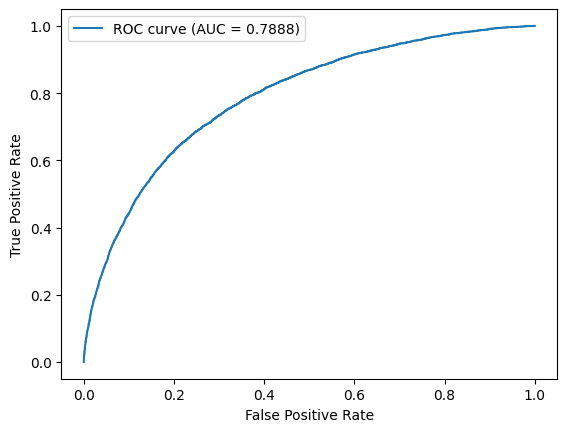

In [ ]:
# --- 1. IMPORTS ---
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation


# --- 2. LOAD DATA ---
# Load merged dataset (adjust path if needed)
data = pd.read_csv('data/prepared/train_full_cor.csv')  # or wherever your merged data is

# Optionally merge TARGET column if missing
target_df = pd.read_csv('input/application_train.csv', usecols=['SK_ID_CURR', 'TARGET'])
if 'TARGET' not in data.columns:
    data = pd.merge(data, target_df, on='SK_ID_CURR', how='left')

# --- 3. FEATURE ENGINEERING ---
# Example: create AGE from DAYS_BIRTH
data['AGE'] = (-data['app_DAYS_BIRTH'] / 365).astype(int)
data.rename(columns={'app_AMT_INCOME_TOTAL': 'INCOME'}, inplace=True)

# Define features & target
features = [col for col in data.columns if col not in ['SK_ID_CURR', 'TARGET']]
X = data[features]
y = data['TARGET']

# --- 4. SPLIT DATA ---
X_train, X_val, y_train, y_val, id_train, id_val = train_test_split(
    X, y, data['SK_ID_CURR'], test_size=0.2, random_state=42, stratify=y
)

def sanitize_columns(df):
    df.columns = df.columns.str.replace(r'[{}"\\/:<>|?*.,;=+()\[\]\' ]', '_', regex=True)
    return df

X_train = sanitize_columns(X_train)
X_val = sanitize_columns(X_val)


# --- 5. DEFINE & TRAIN MODEL ---
model = LGBMClassifier(n_estimators=1000, learning_rate=0.05, random_state=42)


model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping(50), log_evaluation(100)]
)


# --- 6. GET PREDICTIONS ---
val_probs = model.predict_proba(X_val)[:, 1]

# --- 7. EXPORT VALIDATION PREDICTIONS ---
df_val_preds = pd.DataFrame({
    'SK_ID_CURR': id_val,
    'Prediction': val_probs
})
df_val_preds.to_csv('validation_predictions.csv', index=False)
print("Validation predictions saved!")

# --- 8. OPTIONAL: ROC CURVE ---
fpr, tpr, thresholds = roc_curve(y_val, val_probs)
plt.plot(fpr, tpr, label='ROC curve (AUC = %.4f)' % roc_auc_score(y_val, val_probs))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()



In [ ]:
# Save validation predictions to CSV
val_preds = model.predict_proba(X_val)[:, 1]  # get probability for positive class
pd.DataFrame({
    "SK_ID_CURR": id_val,
    "PREDICTION": val_preds
}).to_csv("validation_predictions.csv", index=False)

print("validation_predictions.csv saved!")

validation_predictions.csv saved!


In [ ]:
model.booster_.save_model('output/model.txt')
